In [1]:
# Look at the RGB channels for best contrast

import os
import numpy as np 
import matplotlib.pyplot as plt
import imageio as iio
import nibabel as nib
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import summarize_intensities

FILENAME = './cells.png'
cell_arr = iio.imread(FILENAME)[:, :, 0:3]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
im = axs[0].imshow(cell_arr)

R_arr = cell_arr.copy()
R_arr[:,:,1:3] = 0
im = axs[1].imshow(R_arr)

G_arr = cell_arr.copy()
G_arr[:,:,0:3:2] = 0
im = axs[2].imshow(G_arr)

B_arr = cell_arr.copy()
B_arr[:,:,0:2] = 0
im = axs[3].imshow(B_arr)

fig.tight_layout()
plt.show()

<Figure size 1600x400 with 4 Axes>

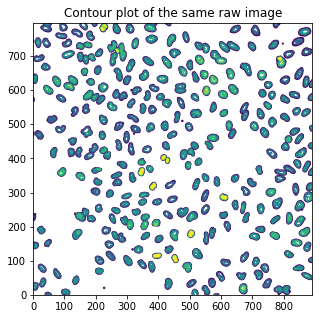

In [2]:
# Cell counting does not need an algorithm to be made easier, could be manual on a transformed array!
mean_arr = np.mean(, axis=-1).astype(np.uint8)

fig, ax = plt.subplots(figsize=(5, 5))
qcs = ax.contour(mean_arr, origin='image')
ax.set_title('Contour plot of the same raw image')
plt.show()

Red 12.14768728020418
Green 4.213454019510995
Blue 4.221455484724026
Mean 4.5449578276563125
Max 4.221455484724026


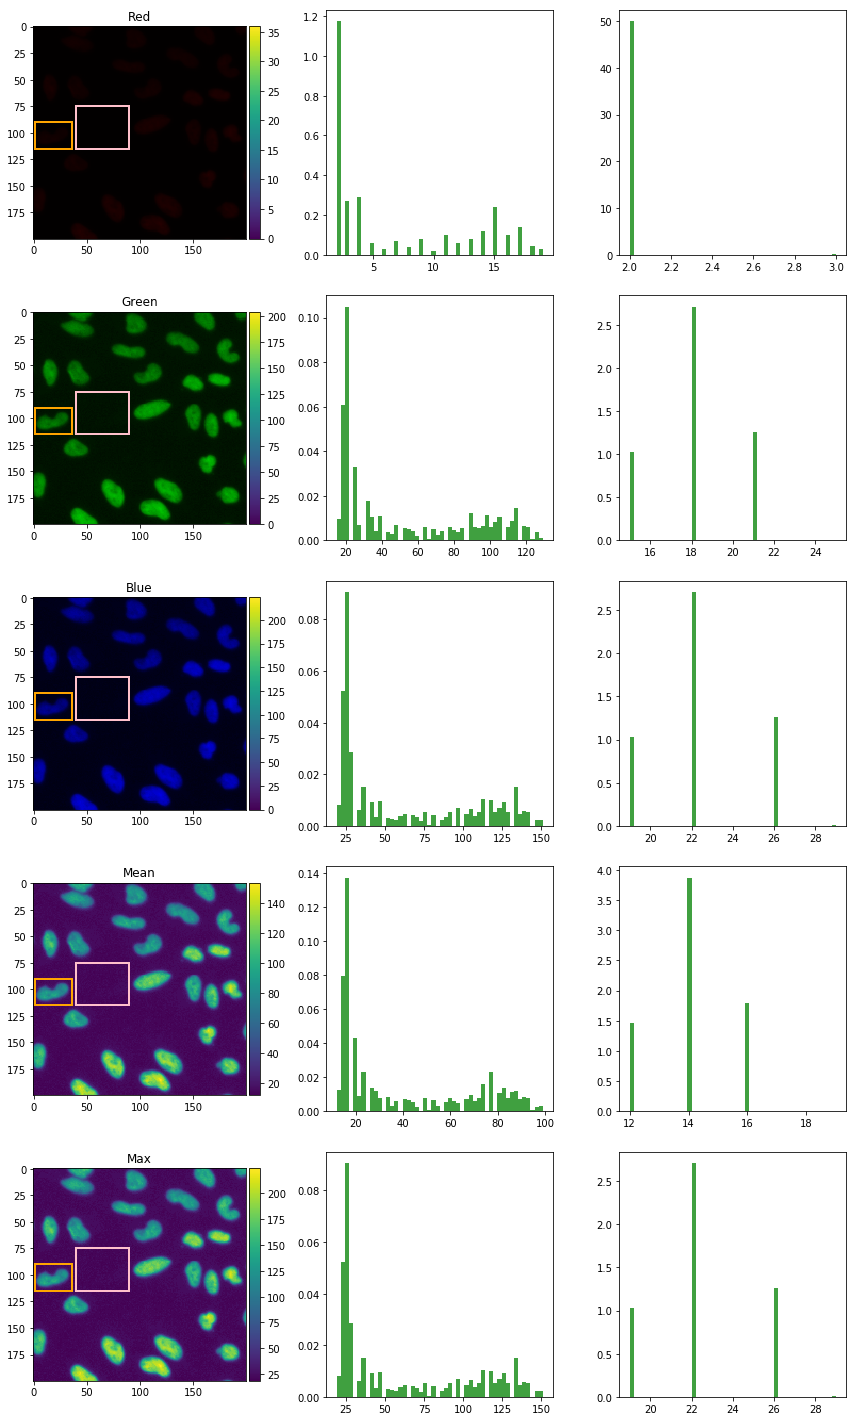

In [3]:
# Compute SNR for each channel (and mean/max)
from matplotlib.patches import Rectangle

def compute_snr_v2(data, corner_s, size_s, corner_n, size_n):
    patch_s = data[corner_s[1]:corner_s[1]+size_s[1], corner_s[0]:corner_s[0]+size_s[0]]
    patch_n = data[corner_n[1]:corner_n[1]+size_n[1], corner_n[0]:corner_n[0]+size_n[0]]
    
    std_s = np.std(patch_s)
    std_n = np.std(patch_n)

    return np.sqrt(std_s/std_n), patch_s, patch_n

# Manually found for this specific image
CORNER_S = (1, 90)
SIZE_S = (35, 25)
CORNER_N = (40, 75)
SIZE_N = (50, 40)

titles = ['Red', 'Green', 'Blue', 'Mean', 'Max']
# Fake 3D
max_arr = np.max(cell_arr, axis=-1).astype(np.uint8)

fig, axs = plt.subplots(5, 3, figsize=(12, 20))
for i, arr in enumerate([R_arr, G_arr, B_arr, mean_arr, max_arr]):
    # The last 2 are in 2D (one channel)
    if i > 2:
        arr = arr[0:200, 0:200]
    else:
        arr = arr[0:200, 0:200, :]

    im = axs[i, 0].imshow(arr)
    axs[i, 0].set_title(titles[i])
    divider = make_axes_locatable(axs[i, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    # The last 2 are in 2D (one chann
    if i > 2:
        snr, patch_s, patch_n = compute_snr_v2(arr[:, :], CORNER_S, SIZE_S,
                                             CORNER_N, SIZE_N)
    else:
        snr, patch_s, patch_n = compute_snr_v2(arr[:, :, i], CORNER_S, SIZE_S,
                                             CORNER_N, SIZE_N)
    n, bins, patches = axs[i, 1].hist(patch_s.ravel(), 50, density=True, facecolor='g', alpha=0.75)
    axs[i, 0].add_patch(Rectangle(CORNER_S, SIZE_S[0], SIZE_S[1],
                              edgecolor='orange',
                              facecolor='none',
                              lw=2))
    n, bins, patches = axs[i, 2].hist(patch_n.ravel(), 50, density=True, facecolor='g', alpha=0.75)
    axs[i, 0].add_patch(Rectangle(CORNER_N, SIZE_N[0], SIZE_N[1],
                                  edgecolor='pink',
                                  facecolor='none',
                                  lw=2))
#     iio.imwrite('s_{}.png'.format(titles[i]), patch_s)
#     iio.imwrite('n_{}.png'.format(titles[i]), patch_n)
    print(titles[i], snr)
fig.tight_layout()
plt.show()

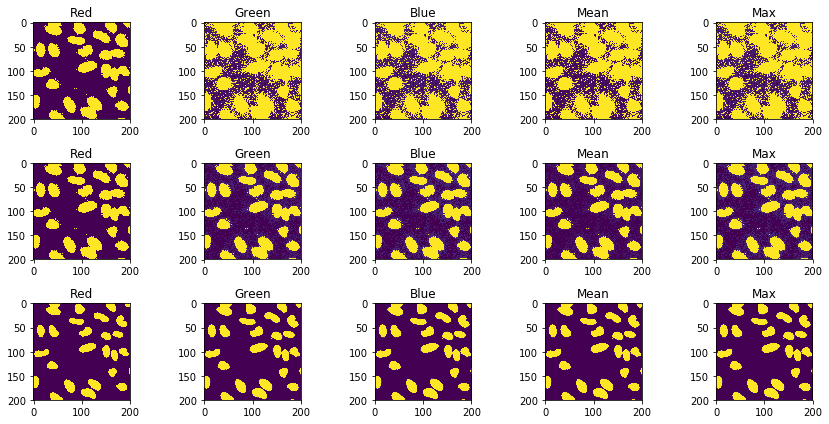

In [4]:
titles = ['Red', 'Green', 'Blue', 'Mean', 'Max']
# Fake 3D
mean_arr = np.mean(cell_arr, axis=-1).astype(np.uint8)
max_arr = np.max(cell_arr, axis=-1).astype(np.uint8)

# Guess a good threshold to initialize the algorithm
fig, axs = plt.subplots(3, 5, figsize=(12, 6))
for i, arr in enumerate([R_arr, G_arr, B_arr, mean_arr, max_arr]):
    for j, val in enumerate([25, 50, 75]):
        if i > 2:
            arr = arr[0:200, 0:200]
            tmp = arr.copy()
        else:
            arr = arr[0:200, 0:200, :]
            tmp = np.sum(arr, axis=-1).copy()
        tmp[tmp > np.percentile(tmp, val)] = 255
        tmp[tmp < np.percentile(tmp, val)] = 0
        im = axs[j, i].imshow(tmp)
        axs[j, i].set_title(titles[i])

fig.tight_layout()
plt.show()

Fit Values: 16.05 and 7.02
Fit Values: 3.23 and 0.92


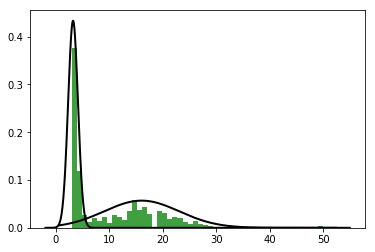

In [9]:
# Automatically detecting a threshold can be used instead of guessing

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

cell_arr = np.sum(R_arr, axis=-1).astype(float)

cell_mask = np.zeros(cell_arr.shape)
cell_mask[cell_arr > np.percentile(cell_arr, 50)] = 1
n, bins, patches = plt.hist(cell_arr[cell_mask > 0], 50, density=True, facecolor='g', alpha=0.75)
X = np.expand_dims(cell_arr[cell_mask > 0], axis=-1)
gm = GaussianMixture(n_components=2, random_state=0).fit(X)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
mu = gm.means_[0, 0]
std = np.sqrt(gm.covariances_[0, 0, 0])
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
print("Fit Values: {:.2f} and {:.2f}".format(mu, std))

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
mu = gm.means_[1, 0]
std = np.sqrt(gm.covariances_[1, 0, 0]) + 0.5
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
print("Fit Values: {:.2f} and {:.2f}".format(mu, std))


# print(X)
# print(gm.means_[1, 0], gm.covariances_[1, 0, 0])
# x = np.linspace(0, len(n), 1000)
# plt.plot(x, norm.pdf(x, gm.means_[0, 0], gm.covariances_[0, 0, 0]))
# plt.plot(x, norm.pdf(x, gm.means_[1, 0], gm.covariances_[1, 0, 0]))
plt.show()

297 peaks were found!


/tmp/ipykernel_5253/1872806007.py:44: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  kmeans = KMeans(n_clusters=np.count_nonzero(peaks), init=init_coord, random_state=0).fit(X)


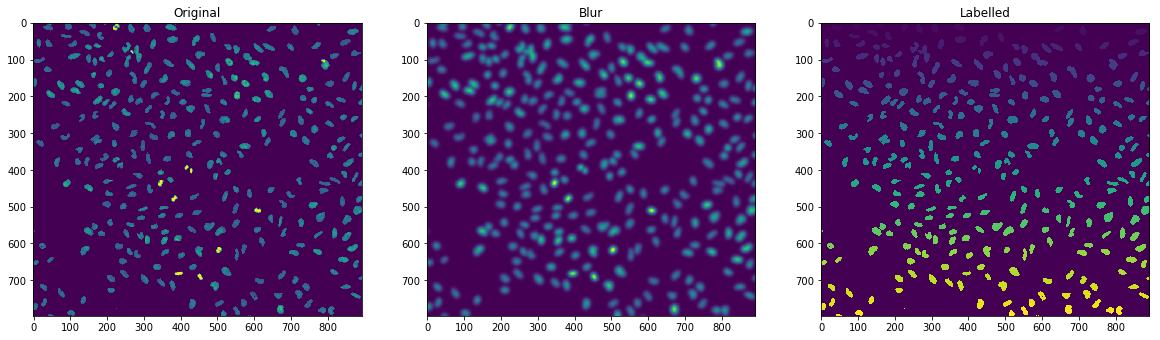

In [10]:
# Find the center of each cell using a peak_filter (local maxima)

from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans

def peak_filter(data, win_size=5, blur=5):
    # Blurring an image can help to increase SNR and avoid extreme case
    data_copy = gaussian_filter(data, sigma=5)
    indices = np.nonzero(data)
    len_indices = len(np.nonzero(data)[0])
    
    new_data = np.zeros(data.shape)
    count = 1
    for i in range(len_indices):
        # Check bound!
        x, y = (indices[0][i], indices[1][i])
        x_min = x-win_size
        x_max = x+win_size+1
        y_min = y-win_size
        y_max = y+win_size+1
        
        if x_min < 0:
            x_min = 0
        if x_max >= data.shape[0]:
            x_min = data.shape[0] - 1
        if y_min < 0:
            y_min = 0
        if y_max >= data.shape[1]:
            y_min = data.shape[1] - 1
        
        # Look around each pixel to see if the current coordinate is a local maxima
        neighborhood = data_copy[x_min:x_max, y_min:y_max]
        if data_copy[x,y] == np.max(neighborhood):
            new_data[x,y] = count
            count += 1
    print('{} peaks were found!'.format(count-1))
    return new_data

def clusters_cells(peaks, mask):
    # Using our peaks detection, launch a k-means algorithm with this initialisation to find each blob
    labels = np.zeros(mask.shape, dtype=np.uint16)
    X = np.argwhere(mask)
    init_coord = np.argwhere(peaks)
    kmeans = KMeans(n_clusters=np.count_nonzero(peaks), init=init_coord, random_state=0).fit(X)
    for i in range(len(X)):
        coord = tuple(X[i])
        labels[coord] = kmeans.labels_[i]

    return labels, kmeans.cluster_centers_

# From earlier mixtures, use the threshold to accelerate computation (remove the vast majority of pixel)
mu = gm.means_[0, 0]
std = np.sqrt(gm.covariances_[0, 0, 0])

cell_mask = cell_arr.copy()
threshold = mu - 1*std
cell_mask[cell_mask < threshold] = 0
cell_mask[cell_mask >= threshold] = 1

cell_arr *= cell_mask
peaks_labels = peak_filter(cell_arr)
labelled_regions, centers = clusters_cells(peaks_labels, cell_mask)

fig, ax = plt.subplots(ncols=3, figsize=(20, 20))
ax[0].imshow(cell_arr)
ax[0].set_title('Original')
ax[1].imshow(gaussian_filter(cell_arr, sigma=5))
ax[1].set_title('Blur')
ax[2].imshow(labelled_regions)
ax[2].set_title('Labelled')
plt.show()

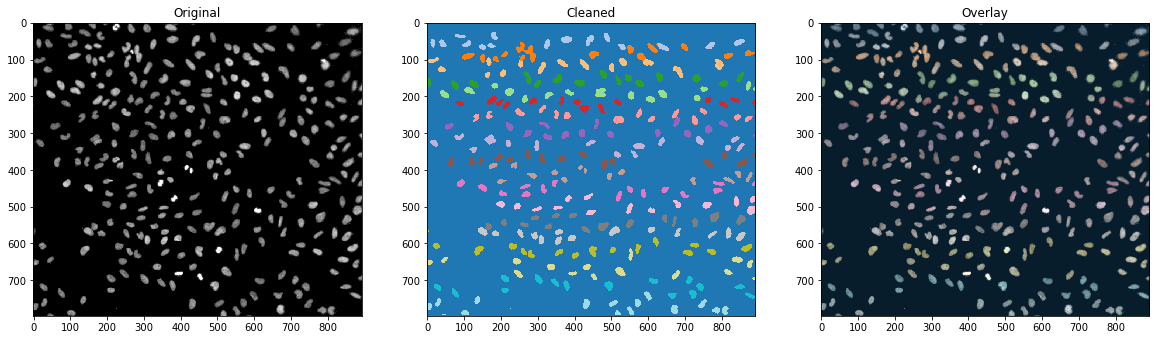

In [11]:
from scipy.ndimage import binary_closing, binary_opening, binary_erosion, binary_dilation

def clean_up_labels(data):
    # Tries to remove hole (empty pixel in cells)
    new_data = np.zeros(data.shape)
    for i in np.unique(data)[1:]:
        tmp = np.zeros(data.shape)
        tmp[data == i] = 1
        tmp = binary_closing(tmp, iterations=3)
        new_data[tmp > 0] = i
    return new_data

cleaned_labels = clean_up_labels(labelled_regions)
fig, ax = plt.subplots(ncols=3, figsize=(20, 20))
ax[0].imshow(mean_arr, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(cleaned_labels, interpolation='nearest', cmap='tab20')
ax[1].set_title('Cleaned')
ax[2].imshow(mean_arr, cmap='gray')
ax[2].imshow(cleaned_labels, interpolation='nearest', cmap='tab20', alpha=0.25)
ax[2].set_title('Overlay')
plt.show()

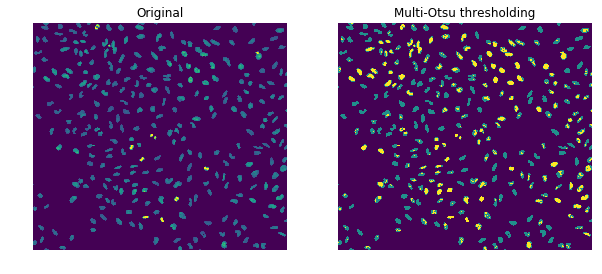

In [12]:
from scipy import ndimage as ndi
from skimage import color, feature, filters, measure, morphology, segmentation, util

# Import a function to simply do the gaussian mixture
thresholds = filters.threshold_multiotsu(cell_arr, classes=3)
regions = np.digitize(cell_arr, bins=thresholds)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(cell_arr)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(regions)
ax[1].set_title('Multi-Otsu thresholding')
ax[1].axis('off')
plt.show()


305 peaks were found!


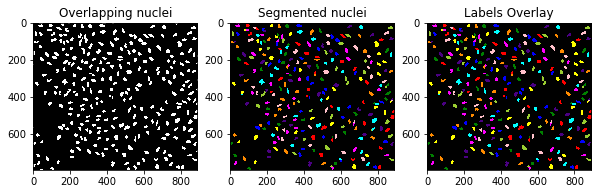

In [13]:
# The library does it faster, better and a lot easier to use!
# But my code is very close!

cells = cell_arr > thresholds[0]
dividing = mean_arr > thresholds[1]
labeled_cells = measure.label(cells)
labeled_dividing = measure.label(dividing)
naive_mi = labeled_dividing.max() / labeled_cells.max()

distance = ndi.distance_transform_edt(cells)

local_max_coords = feature.peak_local_max(distance, min_distance=7)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = measure.label(local_max_mask)

segmented_cells = segmentation.watershed(-distance, markers, mask=cells)
print('{} peaks were found!'.format(len(np.unique(segmented_cells)[1:])))

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(cells, cmap='gray')
ax[0].set_title('Overlapping nuclei')
ax[1].imshow(color.label2rgb(segmented_cells, bg_label=0))
ax[1].set_title('Segmented nuclei')
color_labels = color.label2rgb(segmented_cells, mean_arr, alpha=0.4, bg_label=0)
ax[2].imshow(color.label2rgb(segmented_cells, bg_label=0))
ax[2].set_title('Labels Overlay')
plt.show()